In [2]:
import xarray as xr
import os
# Need to use xbatcher from: https://github.com/arbennett/xbatcher/tree/develop
# See readme for installation instructions
import xbatcher as xb
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
from parflow.tools.io import read_pfb

#import scalers
import yaml

print(os.getcwd())


/home/lc2465/NAIRR/hydrogen-emulator-1ts/notebooks


# Setup the paths to the test case

In [61]:
BASE_DIR = '/Users/laura/Documents/Research/NAIRR/test_box2_conus2_2002WY'

#list of the static files to use
parameter_list= ['slope_x', 'slope_y', 'permeability_x', 'permeability_y' , 'permeability_z',
'porosity',
'pf_flowbarrier', 'mannings', 'specific_storage', 'sres' , 'ssat']
#indicate how many layers of each static parameter file should be used
# 0 indicates all layers should be used
# positive numbers indicate that the bottom n layers should be used
# negative numbers indicate that the top n layers should be used
param_nlayer = [0, 0, -1, 1, -5, 0, 0, 0, 0, 0, 0]

#get the domain sizes from one of the 3D parameter fields (this assumes that all will have the same shape I don't have a check for that built in, also assumes you will correctly pick a 3D one and not a 2D one)
size_test=read_pfb(f'{BASE_DIR}/static/{parameter_list[2]}.pfb')
print(size_test.shape)
X_EXTENT = size_test.shape[2] 
Y_EXTENT = size_test.shape[1]
Z_EXTENT = size_test.shape[0]
T_EXTENT = 1 #This is just for the dummy data for sampling so keep T_EXTENT to 1

#Set the the patch size/overlap to be used for sampling
PATCH_SIZE = 16
PATCH_OVERLAP = 4

# Create a dummy dataset that will be used to pull indices for reading subsets of the data
dummy_data = xr.Dataset().assign_coords({
    'time': np.arange(T_EXTENT),
    'z': np.arange(Z_EXTENT),
    'y': np.arange(Y_EXTENT),
    'x': np.arange(X_EXTENT)
})
print(dummy_data)


(10, 64, 64)
<xarray.Dataset> Size: 1kB
Dimensions:  (time: 1, z: 10, y: 64, x: 64)
Coordinates:
  * time     (time) int64 8B 0
  * z        (z) int64 80B 0 1 2 3 4 5 6 7 8 9
  * y        (y) int64 512B 0 1 2 3 4 5 6 7 8 9 ... 55 56 57 58 59 60 61 62 63
  * x        (x) int64 512B 0 1 2 3 4 5 6 7 8 9 ... 55 56 57 58 59 60 61 62 63
Data variables:
    *empty*


## The batch generator create all of the sets of indices we need to sample the full dataset

In [62]:
#THis is the constructor add dummy data to this
PATCH_SIZE = 20
PATCH_OVERLAP = 4

bgen = xb.BatchGenerator(
    dummy_data,
    input_dims={'x': PATCH_SIZE, 'y': PATCH_SIZE, 'time': 1},
    input_overlap={'x': PATCH_OVERLAP, 'y': PATCH_OVERLAP},
    return_partial=True,
    shuffle=True,
)

#Random print testing can delete later - LC
#print('here')
#print(len(bgen))
#print(bgen[1])
#print('here 2')
#print(bgen[2])
#sample_indices=bgen[2]
#x_min, x_max = sample_indices['x'].values[[0, -1]]
#print(x_min, x_max)

# Now you can see this pulls samples from the dummy data
# Normally you would loop over this, but I can just do 
# this to grab the first sample
sample_indices = next(iter(bgen))

# Pulling the indices we need
time_index = sample_indices['time'].values[0]
x_min, x_max = sample_indices['x'].values[[0, -1]]
y_min, y_max = sample_indices['y'].values[[0, -1]]

# Setting up the keys dictionary
patch_keys = {
    'x': {'start': x_min, 'stop': x_max+1},
    'y': {'start': y_min, 'stop': y_max+1},
}

print(patch_keys)


{'x': {'start': np.int64(48), 'stop': np.int64(64)}, 'y': {'start': np.int64(16), 'stop': np.int64(36)}}


### Getting the pressure files

In [63]:
# Get Pressure files
pressure_files = sorted(glob(f'{BASE_DIR}/transient/pressure*.pfb'))
pressure_files = {
    't': pressure_files[0:-1],
    't+1': pressure_files[1:]
}

# Construct the state data:
file_to_read = pressure_files['t'][time_index]
print(file_to_read)

state_data = read_pfb(file_to_read, keys=patch_keys)

# Construct the target data:
file_to_read_target = pressure_files['t+1'][time_index]
target_data = read_pfb(file_to_read_target, keys=patch_keys)

# Forcings and targets now have dims
# (layers, y, x)
print(state_data.shape, target_data.shape)


/Users/laura/Documents/Research/NAIRR/test_box2_conus2_2002WY/transient/pressure.00000.pfb
(10, 20, 16) (10, 20, 16)


### Pulling the static field data

In [64]:
parameter_data = []
for parameter in parameter_list:
    file_name=f'{BASE_DIR}/static/{parameter}.pfb'
    print(file_name)
    parameter_data.append(read_pfb(file_name, keys=patch_keys))

#Add the ET for the current timestep
#file_name_et=file_to_read.replace('pressure', 'evaptrans')
#print(file_name_et)
#parameter_data.append(read_pfb(file_name_et, #keys=patch_keys))

# Concatenate the parameter data together
# End result is a dims of (n_parameters, y, x)
parameter_data = np.concatenate(parameter_data, axis=0)
parameter_data.shape

/Users/laura/Documents/Research/NAIRR/test_box2_conus2_2002WY/static/slope_x.pfb
/Users/laura/Documents/Research/NAIRR/test_box2_conus2_2002WY/static/slope_y.pfb
/Users/laura/Documents/Research/NAIRR/test_box2_conus2_2002WY/static/permeability_x.pfb
/Users/laura/Documents/Research/NAIRR/test_box2_conus2_2002WY/static/permeability_y.pfb
/Users/laura/Documents/Research/NAIRR/test_box2_conus2_2002WY/static/permeability_z.pfb
/Users/laura/Documents/Research/NAIRR/test_box2_conus2_2002WY/static/porosity.pfb
/Users/laura/Documents/Research/NAIRR/test_box2_conus2_2002WY/static/pf_flowbarrier.pfb
/Users/laura/Documents/Research/NAIRR/test_box2_conus2_2002WY/static/mannings.pfb
/Users/laura/Documents/Research/NAIRR/test_box2_conus2_2002WY/static/specific_storage.pfb
/Users/laura/Documents/Research/NAIRR/test_box2_conus2_2002WY/static/sres.pfb
/Users/laura/Documents/Research/NAIRR/test_box2_conus2_2002WY/static/ssat.pfb


(83, 20, 16)

### Testing scaling the pressure data

/Users/laura/Documents/Research/NAIRR/hydrogen-emulator-1ts
-1.5365720188274083 0.6219785299576331
-42.624761105036576 17.254239085096202
0 : 5000064.399121741 , 3054536.842966496
1 : 991135.0305982605 , 1298836.0932454276
2 : 106074.81835973557 , 257747.0325178825
3 : 6432.6919912145195 , 27103.89204780729
4 : -260.14593460272994 , 1729.746844127095
5 : -132.32387493454831 , 201.72651647015962
6 : -33.515867653191684 , 45.90643399576968
7 : -44.697438677166815 , 29.771451779453066
8 : -48.299928879549235 , 22.682676623317136
9 : -42.624761105036576 , 17.254239085096202


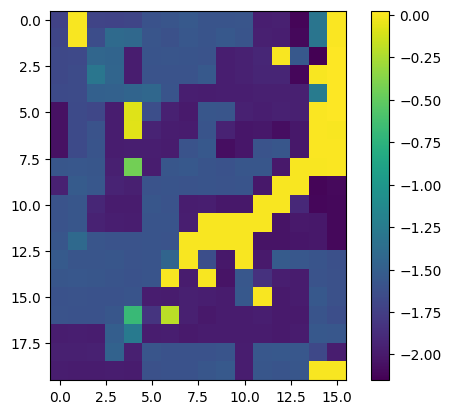

In [65]:
# Testing scalling the pressure data
#Copied from scalers.py
class BaseScaler:
    """ Implements base methods that all scalers should inherit """

    def fit_transform(self, x):
        self.fit(x)
        return self.transform(x)

#Copied from scalers.py
class StandardScaler(BaseScaler):
    """
    The StandardScaler standardizes data by subtracting the
    mean and dividing by the standard deviation of the data
    """

    def __init__(self, mean=None, std=None, **kwargs):
        self.eps = 1e-6
        self.mean = mean
        self.std = std

    def fit(self, x, unbiased=False):
        self.mean = x.mean()
        self.std = x.std(unbiased=unbiased)

    def transform(self, x):
        y = (x - self.mean) / (self.std + self.eps)
        return y

    def inverse_transform(self, y):
        x = y * (self.std + self.eps) + self.mean
        return x

print(os.getcwd())
file = './notebooks/default_scalers.yaml'
with open(file, 'r') as f:
       lookup = yaml.load(f, Loader=yaml.FullLoader)
scalers = {}
for k, v in lookup.items():
    #print('K', k)
    scalers[k] = StandardScaler(float(v['mean']), float(v['std']))
print(scalers['press_diff_0'])

plt.imshow(state_data[9, :, :])
plt.colorbar()

print(np.mean(state_data[9, :, :]), np.std(state_data[9, :, :]))

#test= (state_data[0, :, :] - (-2.8628012241080942e-06))/(3.2339409258506475e-05 + 1e-6) 
test= (state_data[9, :, :] - (-4.026444792345023e-05))/(0.03604686782483403 + 1e-6)
print(np.mean(test), np.std(test))

for k in range(10):
    #print(np.mean(state_data[k]))
    #print(np.std(state_data[k]))
    state_data[k]= scalers[f'press_diff_{k}'].transform(state_data[k])
    print(k, ':', np.mean(state_data[k]), ',' , np.std(state_data[k]))
    #print(np.std(state_data[k]))

## Test scaling the static parameters

In [73]:
print(param_nlayer)
parameter_data = []
for (parameter, n_lay) in zip(parameter_list, param_nlayer):
    #print(parameter, n_lay)
    file_name=f'{BASE_DIR}/static/{parameter}.pfb'
    print(file_name)
    param_temp=read_pfb(file_name, keys=patch_keys)
    if param_temp.shape[0] == 1:
        param_temp = scalers[f'{parameter}'].transform(param_temp)
        #print(parameter, "2D scaling")
    else: 
        #print(parameter, "3D scaling")
        for k in range(param_temp.shape[0]):
            param_temp[k]= scalers[f'{parameter}_{k}'].transform(param_temp[k])

        #Grab the top n bottom or top layers if specified in the param_nlayer list
        if n_lay > 0:
            #print("Grabbing from the bottom")
            param_temp = param_temp[0:n_lay,:,:]
            #print(param_temp.shape)
        elif n_lay < 0:
            #print("Grabbing from the top")
            param_temp = param_temp[n_lay:,:,:]
            #print(param_temp.shape)
            
    parameter_data.append(param_temp)

#Add the ET for the current timestep
#file_name_et=file_to_read.replace('pressure', 'evaptrans')
#print(file_name_et)
#parameter_data.append(read_pfb(file_name_et, #keys=patch_keys))
print("STARTING ET")
n_evaptrans=-4
file_name_et=file_to_read.replace('pressure', 'evaptrans')
evaptrans = (read_pfb(file_name_et, keys= patch_keys))
for k in range(10):
    #print("before", np.mean(evaptrans[k]))
    evaptrans[k]= scalers[f'evaptrans_{k}'].transform(evaptrans[k])
    print("after", np.mean(evaptrans[k]))
#Grab the top n bottom or top layers if specified in the param_nlayer list
#Grab the bottom n_lay layers
if n_evaptrans > 0:
    evaptrans = evaptrans[0:n_evaptrans,:,:]
#Grab the top n_lay layers
elif n_evaptrans < 0:
    #evaptrans = evaptrans[(n_evaptrans-1):-1,:,:]
    evaptrans = evaptrans[n_evaptrans:,:,:]

print(evaptrans.shape)
print(np.mean(evaptrans)) 
for k in range(evaptrans.shape[0]):
    print(np.mean(evaptrans[k]))
    #print(np.std(state_data[k]))


# Concatenate the parameter data together
# End result is a dims of (n_parameters, y, x)
parameter_data = np.concatenate(parameter_data, axis=0)
parameter_data.shape



[0, 0, -1, 1, -5, 0, 0, 0, 0, 0, 0]
/Users/laura/Documents/Research/NAIRR/test_box2_conus2_2002WY/static/slope_x.pfb
/Users/laura/Documents/Research/NAIRR/test_box2_conus2_2002WY/static/slope_y.pfb
/Users/laura/Documents/Research/NAIRR/test_box2_conus2_2002WY/static/permeability_x.pfb
/Users/laura/Documents/Research/NAIRR/test_box2_conus2_2002WY/static/permeability_y.pfb
/Users/laura/Documents/Research/NAIRR/test_box2_conus2_2002WY/static/permeability_z.pfb
/Users/laura/Documents/Research/NAIRR/test_box2_conus2_2002WY/static/porosity.pfb
/Users/laura/Documents/Research/NAIRR/test_box2_conus2_2002WY/static/pf_flowbarrier.pfb
/Users/laura/Documents/Research/NAIRR/test_box2_conus2_2002WY/static/mannings.pfb
/Users/laura/Documents/Research/NAIRR/test_box2_conus2_2002WY/static/specific_storage.pfb
/Users/laura/Documents/Research/NAIRR/test_box2_conus2_2002WY/static/sres.pfb
/Users/laura/Documents/Research/NAIRR/test_box2_conus2_2002WY/static/ssat.pfb
STARTING ET
after 0.0
after 0.0
after 0.

(60, 20, 16)

### Random testing stuff don't need

### Testing scalers

In [ ]:
#Copied from scalers.py
class BaseScaler:
    """ Implements base methods that all scalers should inherit """

    def fit_transform(self, x):
        self.fit(x)
        return self.transform(x)

#Copied from scalers.py
class StandardScaler(BaseScaler):
    """
    The StandardScaler standardizes data by subtracting the
    mean and dividing by the standard deviation of the data
    """

    def __init__(self, mean=None, std=None, **kwargs):
        self.eps = 1e-6
        self.mean = mean
        self.std = std

    def fit(self, x, unbiased=False):
        self.mean = x.mean()
        self.std = x.std(unbiased=unbiased)

    def transform(self, x):
        y = (x - self.mean) / (self.std + self.eps)
        return y

    def inverse_transform(self, y):
        x = y * (self.std + self.eps) + self.mean
        return x


    
# Testing reading in scalers
file = 'default_scalers.yaml'
with open(file, 'r') as f:
       lookup = yaml.load(f, Loader=yaml.FullLoader)
scalers = {}
for k, v in lookup.items():
    print('K', k)
    scalers[k] = StandardScaler(float(v['mean']), float(v['std']))
print(scalers)

# Need to apply the transforms now -- this won't work 
#I think I need to adapt the transform function above but I'm not sure
param_transform = scalers.transform(parameter_data)



K slope_x
K slope_y
K permeability_x_0
K permeability_x_1
K permeability_x_2
K permeability_x_3
K permeability_x_4
K permeability_x_5
K permeability_x_6
K permeability_x_7
K permeability_x_8
K permeability_x_9
K permeability_y_0
K permeability_y_1
K permeability_y_2
K permeability_y_3
K permeability_y_4
K permeability_y_5
K permeability_y_6
K permeability_y_7
K permeability_y_8
K permeability_y_9
K permeability_z_0
K permeability_z_1
K permeability_z_2
K permeability_z_3
K permeability_z_4
K permeability_z_5
K permeability_z_6
K permeability_z_7
K permeability_z_8
K permeability_z_9
K porosity_0
K porosity_1
K porosity_2
K porosity_3
K porosity_4
K porosity_5
K porosity_6
K porosity_7
K porosity_8
K porosity_9
K pf_flowbarrier_0
K pf_flowbarrier_1
K pf_flowbarrier_2
K pf_flowbarrier_3
K pf_flowbarrier_4
K pf_flowbarrier_5
K pf_flowbarrier_6
K pf_flowbarrier_7
K pf_flowbarrier_8
K pf_flowbarrier_9
K mannings
K specific_storage_0
K specific_storage_1
K specific_storage_2
K specific_stora

AttributeError: 'dict' object has no attribute 'transform'

(10, 64, 64)
(10, 64, 64)


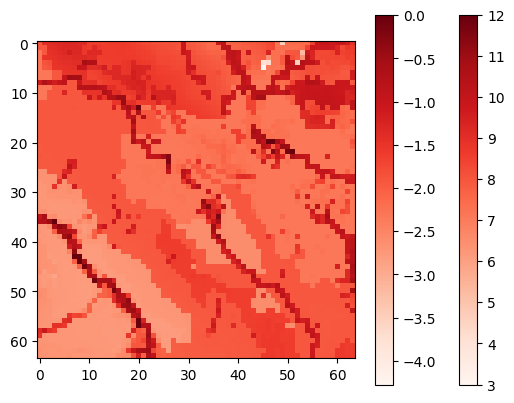

In [8]:
#Test plotting of static input data to make sure everything is lining up okay 
var='pf_indicator'
file_name=f'{BASE_DIR}/static/{var}.pfb'
test = read_pfb(file_name)
print(test.shape)
ni=test.shape[2]
nj=test.shape[1]
layer=9

cmap1 = "Reds"
sub_flip = np.zeros((1, nj, ni))
sub_flip[0, :, :] = test[layer, :, :]
sub_flip = np.flip(sub_flip, 1)

plt.imshow(sub_flip[0, :, :], cmap=cmap1)
plt.colorbar()

# Test plotting of transient input data 
var='pressure'
file_name=f'{BASE_DIR}/transient/{var}.00005.pfb'
test = read_pfb(file_name)
print(test.shape)
ni=test.shape[2]
nj=test.shape[1]
layer=9

cmap1 = "Reds"
sub_flip = np.zeros((1, nj, ni))
sub_flip[0, :, :] = test[layer, :, :]
sub_flip = np.flip(sub_flip, 1)

plt.imshow(sub_flip[0, :, :], cmap=cmap1)
plt.colorbar()